## Importing Libraries and the Dataset

In [1]:
!pip install lexicalrichness

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lexicalrichness: filename=lexicalrichness-0.5.1-py3-none-any.whl size=15418 sha256=a4d80d6f1a934d86bf81e77111b3652a0c7b06b99fa00549ce9de4882cdf1601
  Stored in directory: /root/.cache/pip/wheels/bb/68/f4/1a32ae0aae29ce426b4e3c106a4e8e9c19fd13bcaff45c6a8e
Successfully built lexicalrichness


In [2]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.9 MB/s eta 0:00:00


In [38]:
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.cluster import DBSCAN
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import en_core_web_sm
import csv, sys
from google.colab import drive
import os
from lexicalrichness import LexicalRichness
from rapidfuzz import process, fuzz
import time
from itertools import chain

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
nlp_lemma = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [6]:
nlp_ner = spacy.load("en_core_web_sm", disable=["parser", "textcat"])

### Importing the dataset

In [7]:
csv.field_size_limit(sys.maxsize)

131072

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv(
    '/content/drive/MyDrive/NLP_Project/df_clean.csv',
    sep='§')

print("Loaded rows:", len(df))
df.head()

<ipython-input-9-3648416262>:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(


Loaded rows: 267774


,Unnamed: 0,file,message,Message-ID,Date,From,To,Subject,Body,From_First_Name,...,To_Last_Name,To_Mail,To_External,First_Name,Last_Name,Job_Title,Department,Level,Cleaned_Body,Cleaned_Body_n
0,0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00+00:00,phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast,Phillip,...,Belden,enron.com,False,Phillip,Allen,Managing Director,NaN,High,Here is our forecast,Here is our forecast
1,1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00+00:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,Phillip,...,Lavorato,enron.com,False,Phillip,Allen,Managing Director,NaN,High,Traveling to have a business meeting takes the...,Traveling to have a business meeting takes the...
2,2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00+00:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,Phillip,...,Arsdall,enron.com,False,Phillip,Allen,Managing Director,NaN,High,test successful. way to go!!!,Test successful. Way to go!
3,3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00+00:00,phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s...",Phillip,...,Gay,enron.com,False,Phillip,Allen,Managing Director,NaN,High,"Randy,\n Can you send me a schedule of the sal...",Randy. Can you send me a schedule of the salar...
4,4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00+00:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,Phillip,...,Piper,enron.com,False,Phillip,Allen,Managing Director,NaN,High,Let's shoot for Tuesday at :.,Let's shoot for Tuesday at :.


## Exploratory Data Analysis (EDA)

### Feature Engineering and Tokenization

In [10]:
df['char_length'] = df['Cleaned_Body_n'].astype(str).str.len()
df['word_length'] = df['Cleaned_Body_n'].astype(str).str.split().str.len()
df['avg_word_length'] = df.apply(
    lambda row: row['char_length'] / row['word_length'] if row['word_length'] > 0 else 0,
    axis=1)

In [11]:
stop_words = set(stopwords.words('english'))

# Tokenize words
def tokenize(text):
    if pd.isna(text):
        return []
    tokens = re.findall(r'\b\w+\b', text.lower())  # ignore punctuation
    return [t for t in tokens if t not in stop_words and len(t) > 1]

# Tokenization and count
df['tokens'] = df['Cleaned_Body_n'].apply(tokenize)

In [12]:
level_order = ["High", "Medium", "Low"]
level_colors = {
    'High': '#1f77b4',
    'Medium': '#ff7f0e',
    'Low': '#2ca02c'
}

In [13]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [14]:
df['year_month'] = df['Date'].dt.to_period('M')

<ipython-input-14-88365463>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['Date'].dt.to_period('M')


### Summary Statistics

In [15]:
people_per_level = df[['From', 'Level']].drop_duplicates().groupby('Level').size().reset_index()
people_per_level

,Level,0
0,High,61
1,Low,214
2,Medium,192


In [16]:
df.groupby('Level')['char_length'].mean()

,char_length
Level,
High,205.054512
Low,709.162003
Medium,283.961250


In [17]:
df.groupby('Level')['word_length'].mean()

,word_length
Level,
High,36.768609
Low,117.455349
Medium,49.566936


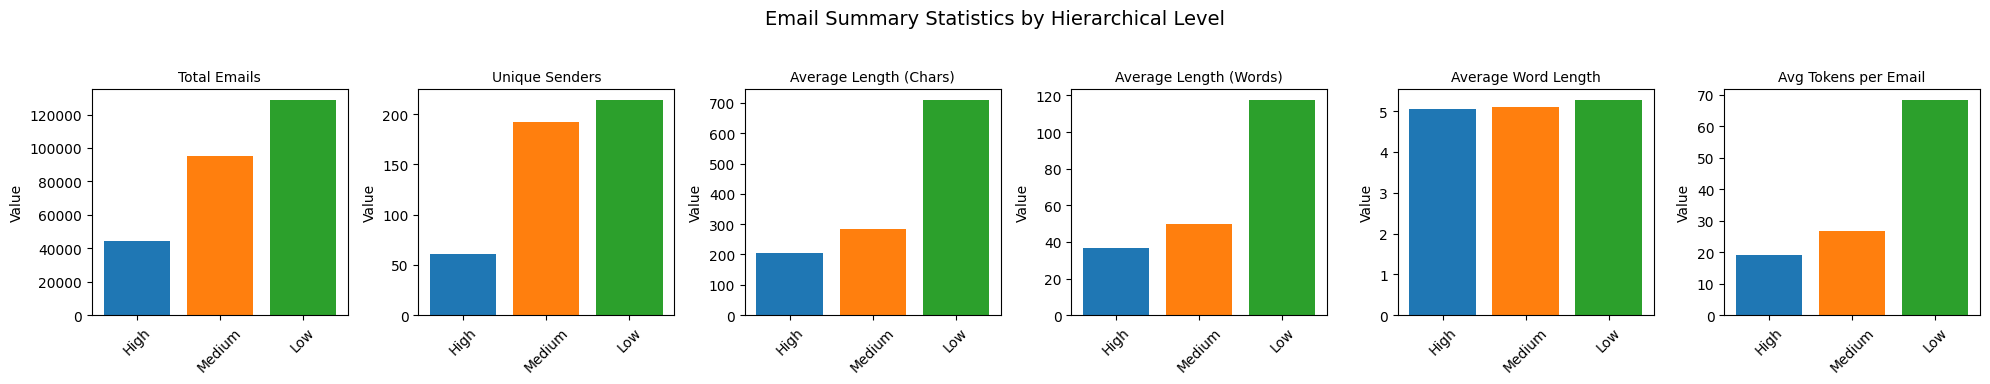

In [18]:
summary_stats = pd.DataFrame({
    'Total Emails': df.groupby('Level').size(),
    'Unique Senders': df.groupby('Level')['From'].nunique(),
    'Average Length (Chars)': df.groupby('Level')['char_length'].mean(),
    'Average Length (Words)': df.groupby('Level')['word_length'].mean(),
    'Average Word Length': df.groupby('Level')['avg_word_length'].mean(),
    'Avg Tokens per Email': df['tokens'].apply(len).groupby(df['Level']).mean(),}).round(2)

summary_stats = summary_stats.reindex(['High', 'Medium', 'Low'])

# Plots
fig, axes = plt.subplots(1, summary_stats.shape[1], figsize=(20, 4))

for i, column in enumerate(summary_stats.columns):
    axes[i].bar(summary_stats.index, summary_stats[column],
        color=[level_colors[level] for level in summary_stats.index])
    axes[i].set_title(column, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Value')

plt.suptitle('Email Summary Statistics by Hierarchical Level', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Lexical Analysis

###### Word frequency

In [19]:
def lemmatize_docs(docs, batch_size=512, n_process=4):
    all_lemmas = []
    for doc in nlp_lemma.pipe(docs, batch_size=batch_size, n_process=n_process):
        lemmas = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha and not token.is_stop and len(token) > 1
        ]
        all_lemmas.append(lemmas)
    return all_lemmas

In [20]:
texts = df["Cleaned_Body_n"].dropna().astype(str)
chunk_size = 8000
lemmas_combined = []

for start in range(0, len(texts), chunk_size):
    end = min(start + chunk_size, len(texts))
    chunk = texts.iloc[start:end].tolist()

    lemmas_chunk = lemmatize_docs(chunk, batch_size=512, n_process=4)
    lemmas_combined.extend(lemmas_chunk)

    print(f"Chunk completed: {start} → {end}")

# Assign lemmas to columns
df.loc[texts.index, "tokens_lemmatized"] = pd.Series(lemmas_combined, index=texts.index)

Chunk completed: 0 → 8000
Chunk completed: 8000 → 16000
Chunk completed: 16000 → 24000
Chunk completed: 24000 → 32000
Chunk completed: 32000 → 40000
Chunk completed: 40000 → 48000
Chunk completed: 48000 → 56000
Chunk completed: 56000 → 64000
Chunk completed: 64000 → 72000
Chunk completed: 72000 → 80000
Chunk completed: 80000 → 88000
Chunk completed: 88000 → 96000
Chunk completed: 96000 → 104000
Chunk completed: 104000 → 112000
Chunk completed: 112000 → 120000
Chunk completed: 120000 → 128000
Chunk completed: 128000 → 136000
Chunk completed: 136000 → 144000
Chunk completed: 144000 → 152000
Chunk completed: 152000 → 160000
Chunk completed: 160000 → 168000
Chunk completed: 168000 → 176000
Chunk completed: 176000 → 184000
Chunk completed: 184000 → 192000
Chunk completed: 192000 → 200000
Chunk completed: 200000 → 208000
Chunk completed: 208000 → 216000
Chunk completed: 216000 → 224000
Chunk completed: 224000 → 230329


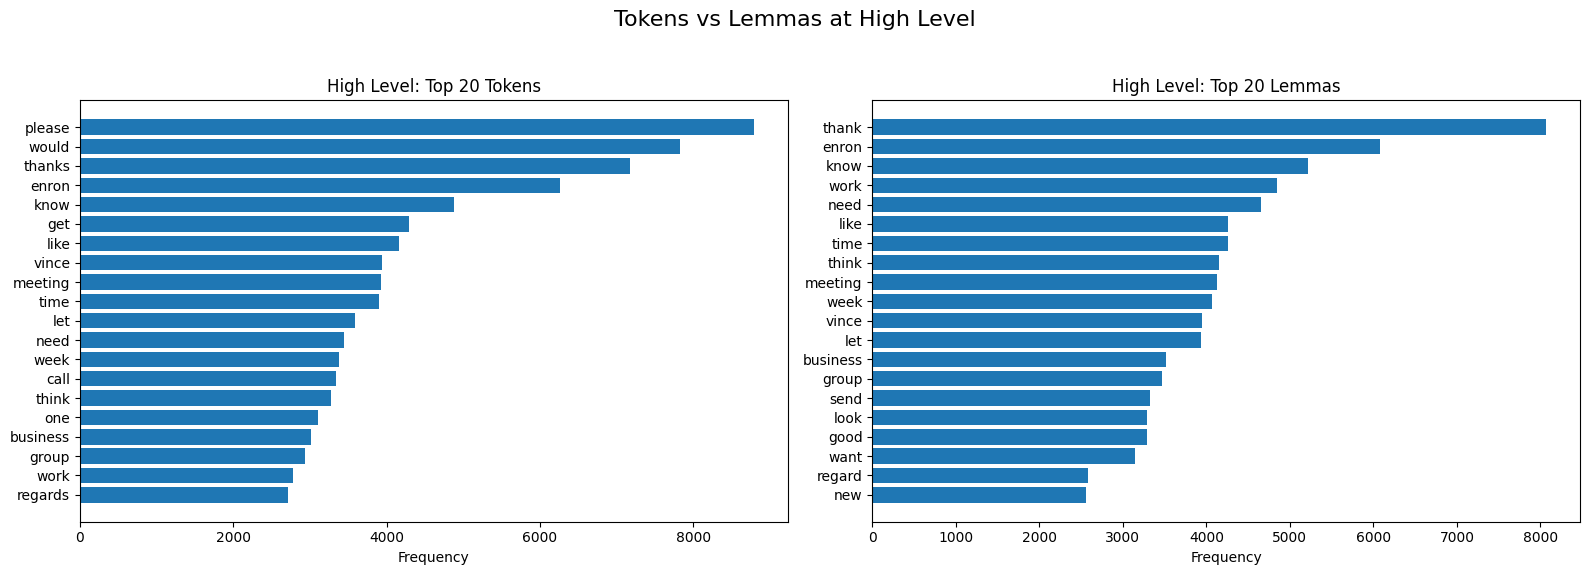

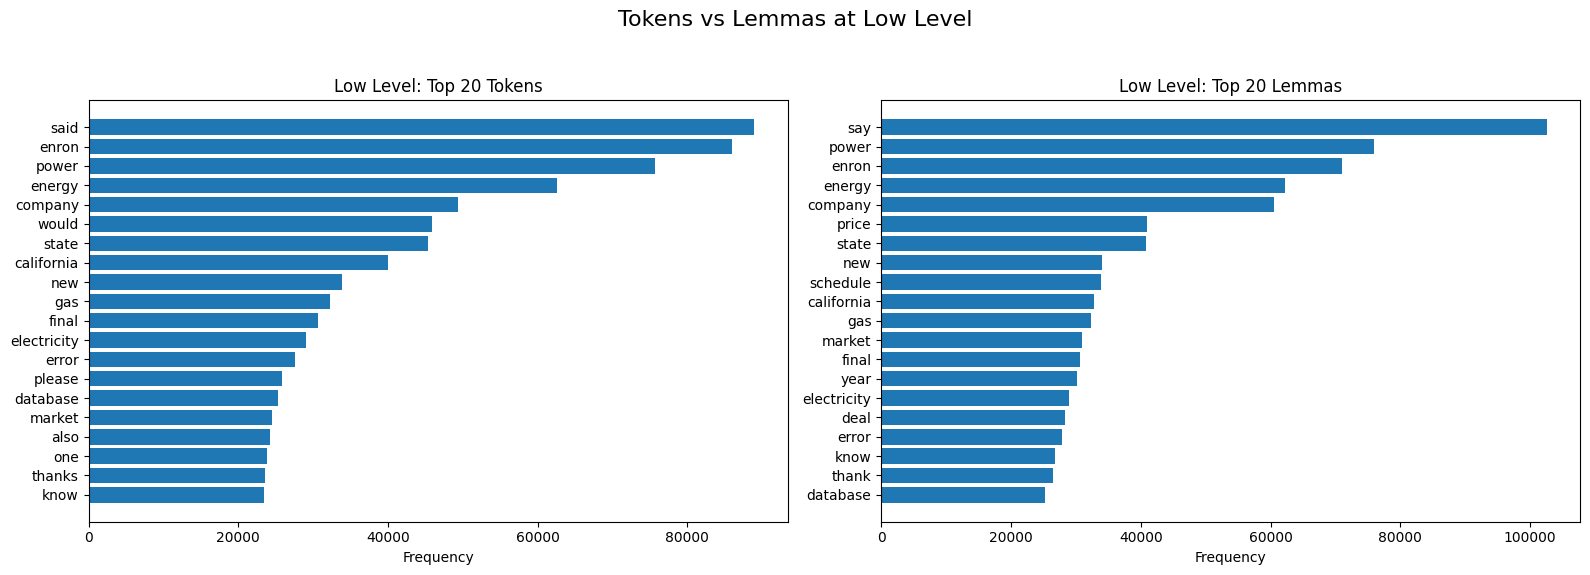

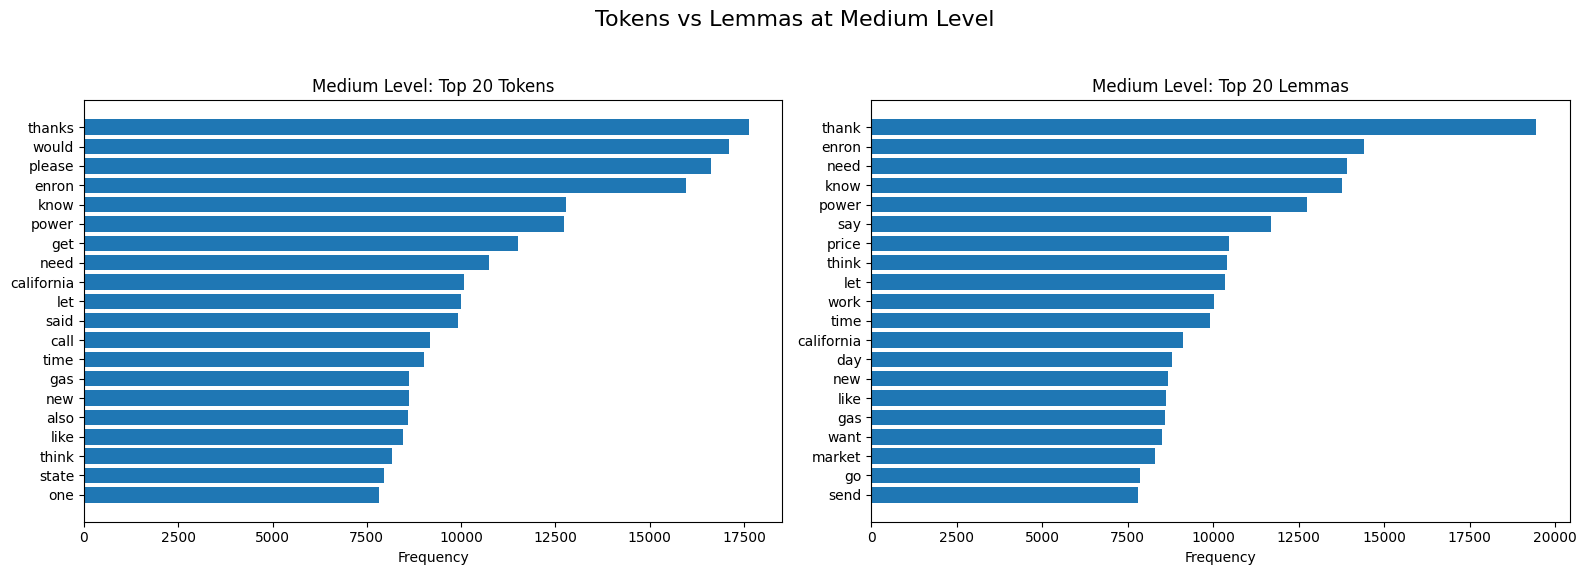

In [21]:
import matplotlib.pyplot as plt
from collections import Counter

levels = df['Level'].dropna().unique()

for lvl in levels:
    # flatten tokens & lemmas for this level
    tokens = [t for sub in df.loc[df['Level'] == lvl, 'tokens'].dropna() for t in sub]
    lemmas = [l for sub in df.loc[df['Level'] == lvl, 'tokens_lemmatized'].dropna() for l in sub]

    top_tokens = Counter(tokens).most_common(20)
    top_lemmas = Counter(lemmas).most_common(20)

    words, wf = zip(*top_tokens)
    lem, lf = zip(*top_lemmas)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)
    # Left: tokens
    axes[0].barh(words, wf)
    axes[0].invert_yaxis()
    axes[0].set_title(f'{lvl} Level: Top 20 Tokens')
    axes[0].set_xlabel('Frequency')

    # Right: lemmas
    axes[1].barh(lem, lf)
    axes[1].invert_yaxis()
    axes[1].set_title(f'{lvl} Level: Top 20 Lemmas')
    axes[1].set_xlabel('Frequency')

    fig.suptitle(f'Tokens vs Lemmas at {lvl} Level', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

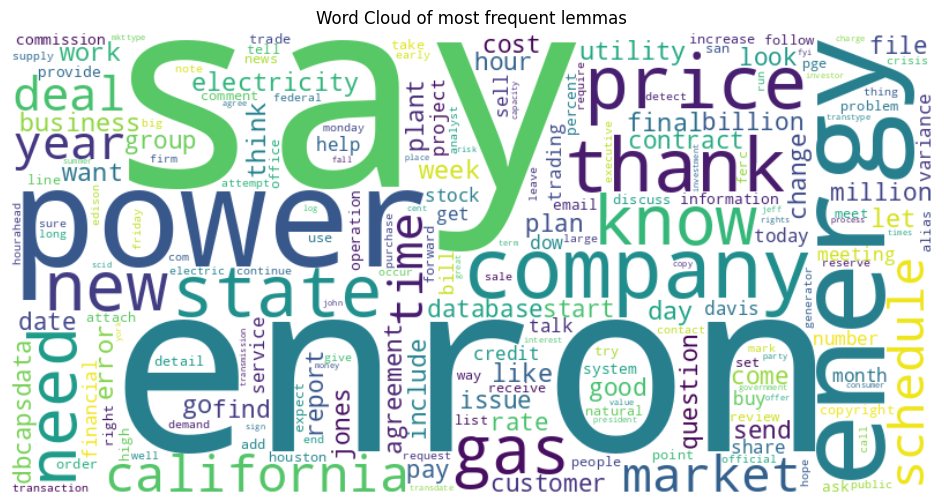

In [22]:
#single graph for all levels
valid_lemmas = df['tokens_lemmatized'].dropna()
all_lemmas   = [lemma for sublist in valid_lemmas for lemma in sublist]
lemma_freq   = Counter(all_lemmas)
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(lemma_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of most frequent lemmas')
plt.show()

###### Semantic categories

In [23]:
def keyword_group_rate(df, keyword_list, group_name):
    pattern = r'\b(?:' + '|'.join(map(re.escape, keyword_list)) + r')\b'
    col_name = f'has_{group_name}'
    df[col_name] = df['Cleaned_Body_n'].str.contains(pattern, case=False, na=False)
    return df.groupby('Level')[col_name].mean().rename(group_name)

# Groups
Courtesy = ['please', 'thanks', 'thank', 'regards', 'sincerely', 'appreciate', 'best']
Orders = ['confirm', 'forward', 'schedule', 'prepare', 'submit', 'review', 'organize','must','fix', 'should']
Crisis = ['crisis', 'issue', 'problem', 'concern', 'urgent', 'delay', 'fail', 'risk', 'pressure']

# Frequency within each category
results_grouped = pd.concat([
    keyword_group_rate(df, Courtesy, 'courtesy'),
    keyword_group_rate(df, Orders, 'orders'),
    keyword_group_rate(df, Crisis, 'crisis')], axis=1)

display(results_grouped.T)

Level,High,Low,Medium
courtesy,0.350899,0.293042,0.328515
orders,0.137300,0.190030,0.157976
crisis,0.060208,0.045770,0.062328


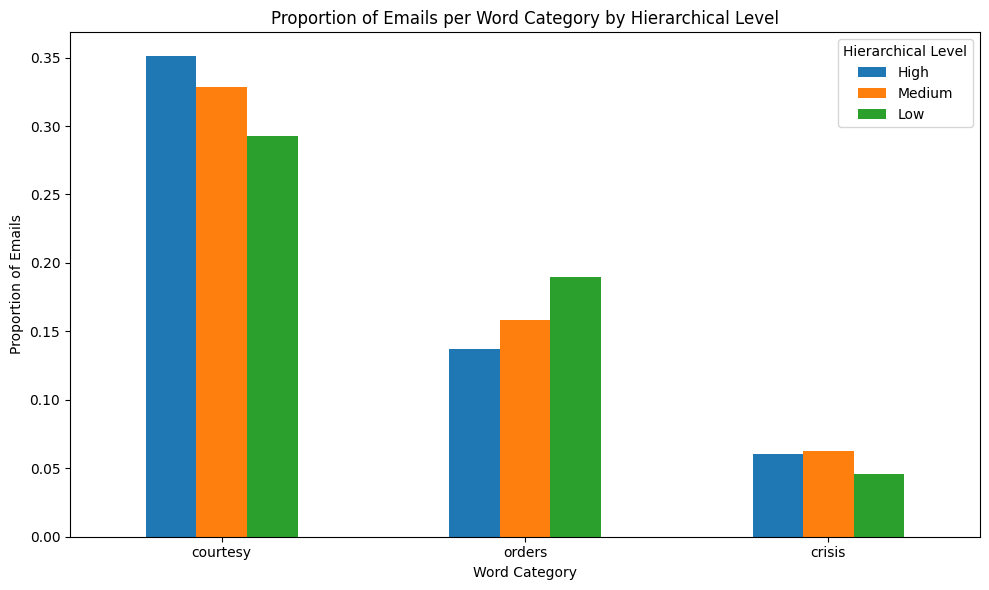

In [24]:
# Bar chart with frequency within each semantic group of word

results_plot = results_grouped.T
results_plot = results_plot[level_order]

results_plot.plot(kind='bar', figsize=(10, 6))
plt.title('Proportion of Emails per Word Category by Hierarchical Level')
plt.xlabel('Word Category')
plt.ylabel('Proportion of Emails')
plt.xticks(rotation=0)
plt.legend(title='Hierarchical Level')
plt.tight_layout()
plt.show()

###### Lexical Diversity

In [25]:
# Compute MTLD
def compute_mtld(tokens):
    if not tokens:
        return 0
    text = ' '.join(tokens)
    return LexicalRichness(text).mtld()

df['mtld'] = df['tokens'].apply(compute_mtld)

mtld_stats = (
    df.groupby('Level')['mtld']
      .mean()
      .round(2)
      .reindex(level_order)
)

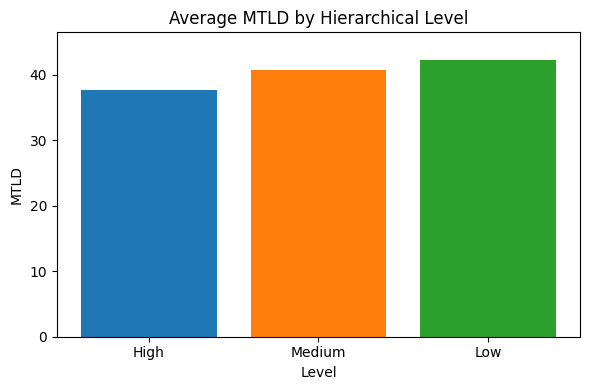

In [26]:
# Plot
title = 'Average MTLD by Hierarchical Level'
plt.figure(figsize=(6, 4))
plt.bar(
    mtld_stats.index,
    mtld_stats.values,
    color=[level_colors[level] for level in level_order]
)
plt.title(title)
plt.xlabel('Level')
plt.ylabel('MTLD')
plt.ylim(0, mtld_stats.max() * 1.1)
plt.tight_layout()
plt.show()

In [27]:
# Compute MATTR
def compute_mattr(tokens, window=25):
    if not tokens or len(tokens) < window:
        return None
    text = ' '.join(tokens)
    return LexicalRichness(text).mattr(window_size=window)

# Apply
df['mattr'] = df['tokens'].apply(lambda x: compute_mattr(x))

mattr_stats = (
    df.groupby('Level')['mattr']
      .mean()
      .round(2)
      .reindex(level_order)
)

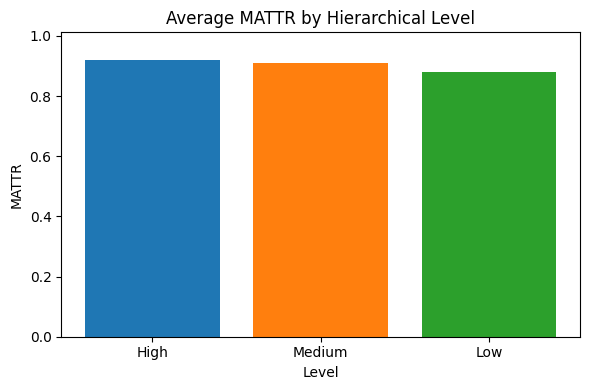

In [28]:
# Plot
plt.figure(figsize=(6, 4))
plt.bar(
    level_order,
    mattr_stats.values,
    color=[level_colors[level] for level in level_order]
)
plt.title('Average MATTR by Hierarchical Level')
plt.xlabel('Level')
plt.ylabel('MATTR')
plt.ylim(0, mattr_stats.max() * 1.1)
plt.tight_layout()
plt.show()

#### NER

In [29]:
def extract_entities(texts):
    return [
        [(ent.text, ent.label_) for ent in doc.ents]
        for doc in nlp_ner.pipe(texts, batch_size=512, n_process=8)]

In [32]:
df["Cleaned_Body_n"] = df["Cleaned_Body_n"].fillna("")
texts = df["Cleaned_Body_n"].astype(str).tolist()

chunk_size = 10000
all_entities = []

for start in range(0, len(texts), chunk_size):
    end = min(start + chunk_size, len(texts))
    chunk = texts[start:end]

    print(f"Processing chunk: {start}–{end}...")
    t0 = time.time()

    chunk_entities = extract_entities(chunk)

    print(f"Done in {time.time() - t0:.2f}s")
    all_entities.extend(chunk_entities)


Processing chunk: 0–10000...
Done in 54.28s
Processing chunk: 10000–20000...
Done in 28.64s
Processing chunk: 20000–30000...
Done in 103.16s
Processing chunk: 30000–40000...
Done in 160.80s
Processing chunk: 40000–50000...
Done in 34.57s
Processing chunk: 50000–60000...
Done in 23.20s
Processing chunk: 60000–70000...
Done in 18.59s
Processing chunk: 70000–80000...
Done in 24.80s
Processing chunk: 80000–90000...
Done in 60.04s
Processing chunk: 90000–100000...
Done in 20.26s
Processing chunk: 100000–110000...
Done in 16.32s
Processing chunk: 110000–120000...
Done in 69.66s
Processing chunk: 120000–130000...
Done in 104.46s
Processing chunk: 130000–140000...
Done in 119.88s
Processing chunk: 140000–150000...
Done in 40.32s
Processing chunk: 150000–160000...
Done in 19.83s
Processing chunk: 160000–170000...
Done in 19.65s
Processing chunk: 170000–180000...
Done in 96.32s
Processing chunk: 180000–190000...
Done in 19.81s
Processing chunk: 190000–200000...
Done in 19.47s
Processing chunk: 2

In [33]:
flat_entities = list(chain.from_iterable(all_entities))

entity_counts = Counter(label for _, label in flat_entities)

print(entity_counts.most_common())

[('ORG', 692094), ('PERSON', 487117), ('DATE', 272329), ('GPE', 191559), ('CARDINAL', 74636), ('NORP', 39640), ('TIME', 36929), ('LOC', 20145), ('ORDINAL', 19892), ('PRODUCT', 18802), ('WORK_OF_ART', 8362), ('MONEY', 8247), ('FAC', 6654), ('LAW', 3904), ('QUANTITY', 2517), ('PERCENT', 2457), ('EVENT', 1974), ('LANGUAGE', 382)]


In [34]:
org_counts = Counter(ent for ent in flat_entities if ent[1] == "ORG")

print(org_counts.most_common(10))

[(('ENRON', 'ORG'), 65128), (('Enron\\', 'ORG'), 16176), (('FERC', 'ORG'), 13916), (('PGE', 'ORG'), 9345), (('Dow Jones Company,', 'ORG'), 8964), (('LOG', 'ORG'), 8246), (('FYI', 'ORG'), 7393), (('ISO', 'ORG'), 6991), (('it\\', 'ORG'), 5896), (('PUC', 'ORG'), 5748)]


Since there is more than one organization referring to Enron we have decided to normalize raw organization names extracted by the NER process, collapsing variants like “Enron Corp.” or “ENRON Direct” into a single form (“enron”). It then recounts mentions of each organization and plots the Top 10 by frequency, giving a more accurate view of organization mentions in our corpus.


In [35]:
def normalize_org(name: str) -> str:
    name = name.lower().strip()
    name = name.replace("\\", "").replace('"', "").replace("'", "")
    for suf in [r"\binc\b", r"\bcorp\b", r"\bcompany\b", r"\bco\b",
                r"\bltd\b", r"'s\b", r"\bonline\b"]:
        name = re.sub(suf, "", name)
    name = re.sub(r"\s+", " ", name).strip()
    name = re.sub(r"^enron\b.*", "enron", name)
    return name

In [36]:
raw_names = [t for t, lbl in flat_entities if lbl == "ORG"]

# Normalize
normalized = [normalize_org(n) for n in raw_names]
normalized = [n for n in normalized if n.strip() != ""]

blacklist = {"fyi", "log", "re", "fw", "hi", "please", "thanks", "en"}

filtered = [n for n in normalized if n not in blacklist and len(n) > 2]
org_counts = Counter(filtered)

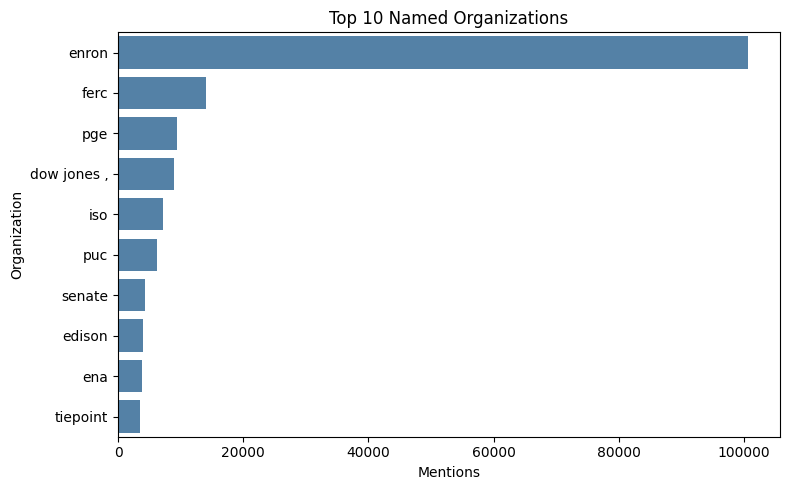

In [48]:
plot_df = (pd.DataFrame(org_counts.most_common(10), columns=["Organization","Mentions"]).sort_values("Mentions", ascending=False))

plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x="Mentions", y="Organization", color="steelblue")
plt.title("Top 10 Named Organizations")
plt.xlabel("Mentions")
plt.ylabel("Organization")
plt.tight_layout()
plt.show()

### Email verbosity

In [39]:
q_low, q_high = df['word_length'].quantile([0.25, 0.75])

def verbosity_label(n):
    if n <= q_low:
        return "Concise"
    elif n >= q_high:
        return "Verbose"
    else:
        return "Normal"

df['verbosity'] = df['word_length'].apply(verbosity_label)

In [40]:
print(df.columns.tolist())

['Unnamed: 0', 'file', 'message', 'Message-ID', 'Date', 'From', 'To', 'Subject', 'Body', 'From_First_Name', 'From_Last_Name', 'From_Mail', 'From_External', 'To_First_Name', 'To_Last_Name', 'To_Mail', 'To_External', 'First_Name', 'Last_Name', 'Job_Title', 'Department', 'Level', 'Cleaned_Body', 'Cleaned_Body_n', 'char_length', 'word_length', 'avg_word_length', 'tokens', 'year_month', 'tokens_lemmatized', 'has_courtesy', 'has_orders', 'has_crisis', 'mtld', 'mattr', 'verbosity']


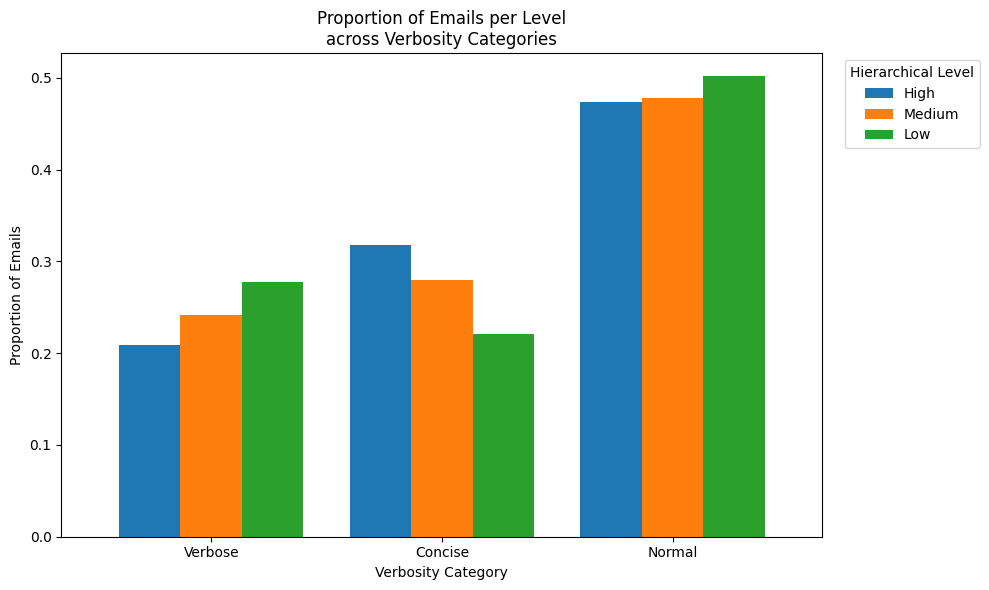

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

counts_lvl = (
    df
    .groupby(['Level', 'verbosity'])
    .size()
    .unstack(fill_value=0)
)

verbosity_order = ['Verbose', 'Concise', 'Normal']

counts_lvl = counts_lvl.reindex(
    index=level_order,
    columns=verbosity_order,
    fill_value=0
)

props_lvl = counts_lvl.div(counts_lvl.sum(axis=1), axis=0)

props_transposed = props_lvl.T.reindex(
    index=verbosity_order,
    columns=level_order
)

fig, ax = plt.subplots(figsize=(10, 6))
props_transposed.plot(
    kind='bar',
    ax=ax,
    width=0.8
)

ax.set_xlabel("Verbosity Category")
ax.set_ylabel("Proportion of Emails")
ax.set_title("Proportion of Emails per Level\nacross Verbosity Categories")
ax.legend(title="Hierarchical Level", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Temporal Analysis

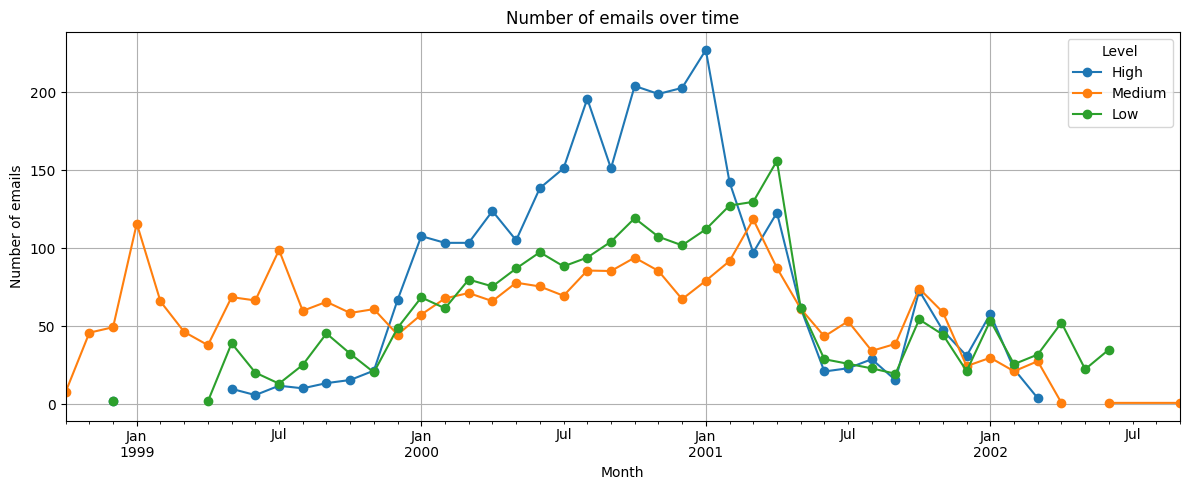

In [42]:
active_users = (df.groupby(['year_month', 'Level'])['From'].nunique().unstack())

emails_by_month_and_level = df.groupby(['year_month', 'Level']).size().unstack()

normalized_per_active_user = emails_by_month_and_level.divide(active_users)

normalized_per_active_user = normalized_per_active_user.reindex(columns=level_order)

colors = [level_colors[level] for level in level_order]

# Plot
ax = normalized_per_active_user.plot(
    kind='line',
    figsize=(12, 5),
    marker='o',
    color=colors
)
plt.title("Number of emails over time")
plt.xlabel("Month")
plt.ylabel("Number of emails")
plt.grid(True)
plt.tight_layout()
plt.show()

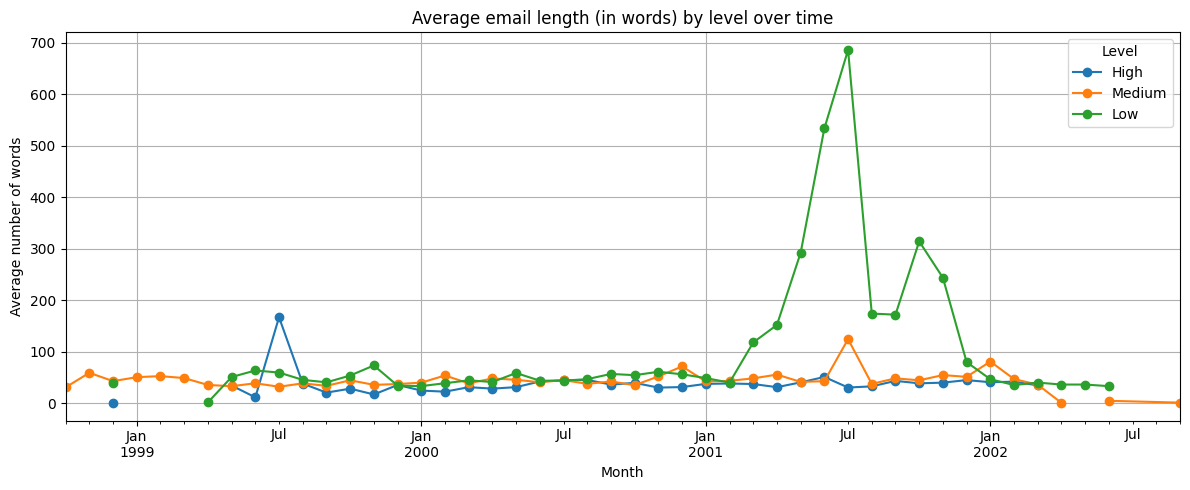

In [43]:
avg_length_by_level = (df.groupby(['year_month', 'Level'])['word_length'].mean().unstack())

avg_length_by_level = avg_length_by_level.reindex(columns=level_order)

colors = [level_colors[level] for level in level_order]

ax = avg_length_by_level.plot(
    kind='line',
    figsize=(12, 5),
    marker='o',
    color=colors
)

plt.title("Average email length (in words) by level over time")
plt.xlabel("Month")
plt.ylabel("Average number of words")
plt.grid(True)
plt.tight_layout()
plt.legend(title='Level')
plt.show()

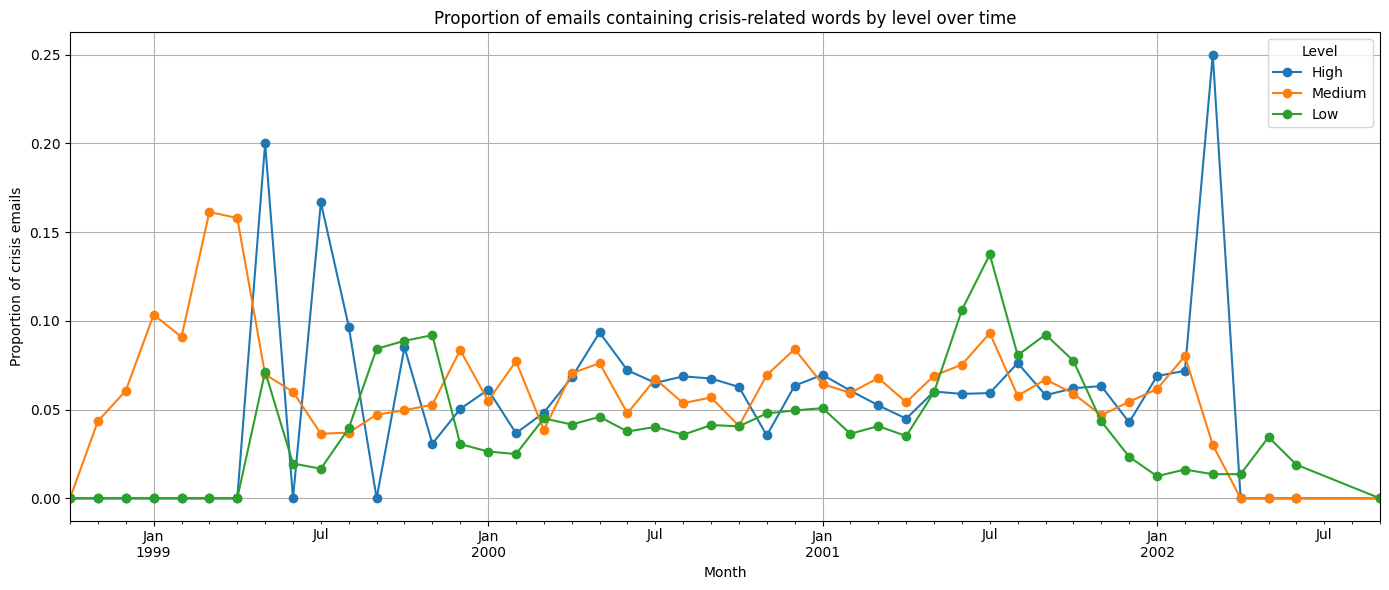

In [44]:
crisis_by_level = (
    df
    .groupby(['year_month', 'Level'])['has_crisis']
    .mean()
    .unstack(fill_value=0)
)

crisis_by_level = crisis_by_level.reindex(columns=level_order)

colors = [level_colors[level] for level in level_order]

ax = crisis_by_level.plot(
    kind='line',
    figsize=(14, 6),
    marker='o',
    color=colors
)

plt.title("Proportion of emails containing crisis-related words by level over time")
plt.xlabel("Month")
plt.ylabel("Proportion of crisis emails")
plt.grid(True)
plt.legend(title='Level')
plt.tight_layout()
plt.show()

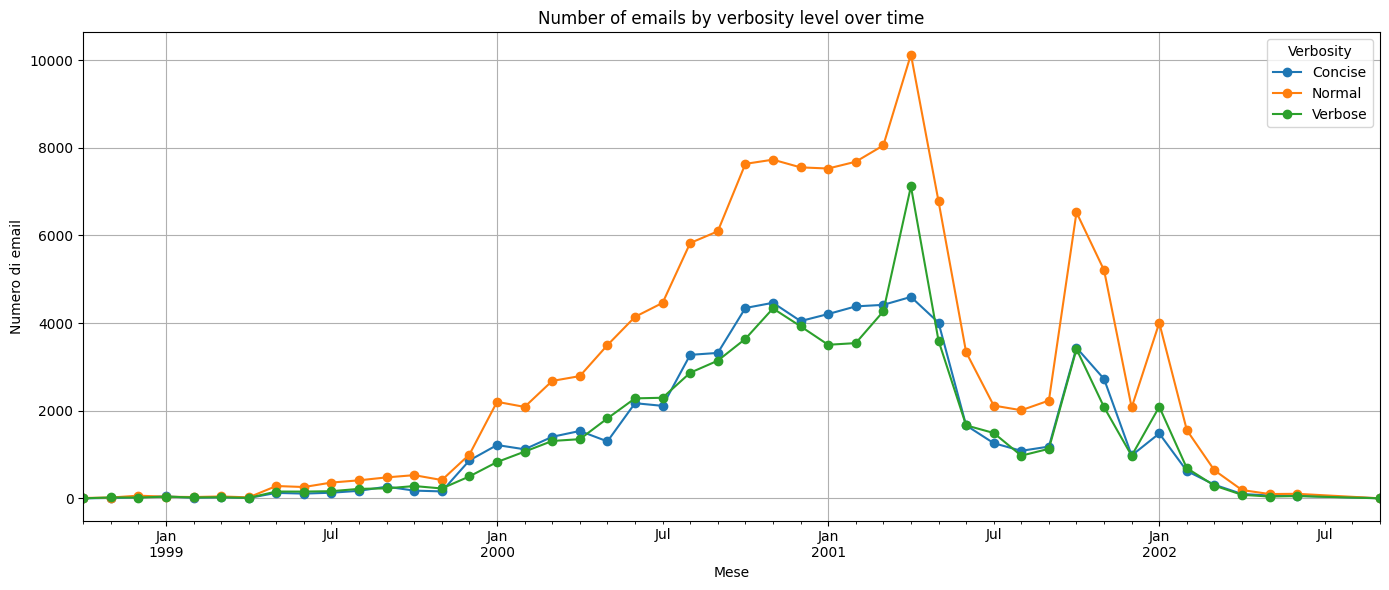

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by mail and verbosity
counts = (
    df
    .groupby(['year_month','verbosity'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Plot
ax = counts.plot(
    figsize=(14, 6),
    marker='o'
)
ax.set_title("Number of emails by verbosity level over time")
ax.set_xlabel("Mese")
ax.set_ylabel("Numero di email")
ax.grid(True)
ax.legend(title='Verbosity')
plt.tight_layout()
plt.show()

### Pre Topic Modelling Analysis

In [46]:
raw_docs = df['Cleaned_Body_n'].dropna().astype(str).tolist()

valid_lemmas = df["tokens_lemmatized"].dropna()
documents_str = [" ".join(tokens) for tokens in valid_lemmas]

# Vectorize strings
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    min_df=5,
    max_df=0.6,
    max_features=10000  # limit to most frequent 10k terms
)

dtm = vectorizer.fit_transform(documents_str)

# Extract vocab & frequencies
vocab = vectorizer.get_feature_names_out()
print(f"Vocabulary size after lemmatization: {len(vocab)}")

word_counts = np.asarray(dtm.sum(axis=0)).flatten()
freq_df = pd.DataFrame({'term': vocab, 'count': word_counts}).sort_values('count', ascending=False)

print("\nTop 10 most frequent lemmatized words:")
print(freq_df.head(10))

print("\nTop 10 least frequent lemmatized words (but ≥ min_df):")
print(freq_df.tail(10))

total_elements   = dtm.shape[0] * dtm.shape[1]
nonzero_elements = dtm.nnz
sparsity         = 1.0 - (nonzero_elements / total_elements)
print(f"\nSparsity of the lemmatized document-term matrix: {sparsity:.4f}")

Vocabulary size after lemmatization: 10000

Top 10 most frequent lemmatized words:
         term   count
7895      say  115002
3002    enron   91462
6853    power   90401
2959   energy   71198
1685  company   68637
8992    thank   53989
6955    price   53269
8522    state   48856
4932     know   45795
5998      new   45249

Top 10 least frequent lemmatized words (but ≥ min_df):
             term  count
1848  contaminate     54
8024      sellers     54
8610      strauss     54
8550       steffe     54
8360     solidify     54
549       assuage     54
531    assetlight     54
8907        tease     54
1270    carpenter     54
6438    packaging     54

Sparsity of the lemmatized document-term matrix: 0.9977


In [47]:
df['tokens_str'] = df['tokens'].str.join(' ')
df['tokens_lemmatized_str'] = df['tokens_lemmatized'].str.join(' ')

### Saving Dataset

In [ ]:
drive_path = '/content/drive/MyDrive/NLP_Project/data.csv'

df.to_csv(drive_path,sep='§')